# Description
The purpose of this notebook is to take the "cleaned" csv file as an input, and then further refine/split the data for future SQL tables creation. 

---

# About the data
This dataset (Ask A Manager Salary Survey 2021 dataset) contains salary information by industry, age group, location, gender, years of experience, and education level. The data is based on approximately 28k user entered responses.

**Features:**
- `timestamp` - time when the survey was filed
- `age` - Age range of the person
- `industry` - Working industry
- `job_title` - Job title
- `job_context` - Additional context for the job title
- `annual_salary` - Annual salary
- `additional_salary` - Additional monetary compensation
- `currency` - Salary currency
- `currency_context` - Other currency
- `salary_context` - Additional context for salary
- `country` -  Country in which person is working
- `state` - State in which person is working
- `city` - City in which person is working
- `total_experience` -  Year  range of total work experience
- `current_experience` - Year range of current field  work experience
- `education` - Highest level of education completed
- `gender` - Gender of the person
- `race` - Race of the person

# Reading the file

In [1]:
import pandas as pd

data = pd.read_csv('Data/salary_responses_clean.csv')

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27848 entries, 0 to 27847
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   timestamp           27848 non-null  object 
 1   age                 27848 non-null  object 
 2   industry            27778 non-null  object 
 3   job_title           27848 non-null  object 
 4   job_context         7204 non-null   object 
 5   annual_salary       27848 non-null  int64  
 6   additional_salary   20634 non-null  float64
 7   currency            27848 non-null  object 
 8   currency_context    191 non-null    object 
 9   salary_context      3026 non-null   object 
 10  country             27848 non-null  object 
 11  state               22894 non-null  object 
 12  city                27773 non-null  object 
 13  total_experience    27848 non-null  object 
 14  current_experience  27848 non-null  object 
 15  education           27638 non-null  object 
 16  gend

# Categorical data
Let's handle the categorical data first.

**Categorical features include:**
- `age`
- `total_experience`
- `current_experience`
- `education`
- `gender`


*The `state`, `race` and `currency` attributes can also be considered categorical, but more cleaning need to be done. We will leave it for now.*

## Age

In [3]:
data['age'].value_counts()

25-34         12562
35-44          9853
45-54          3171
18-24          1173
55-64           986
65 or over       92
under 18         11
Name: age, dtype: int64

In [4]:
data['age'].isnull().sum()

0

Lets create new columns `age_min` and `age_max` so we could more easily analyze the data.

In [5]:
import numpy as np

In [6]:
def age_range_to_min(row):
    age_range = row['age']
    
    if '-' in age_range:
        age_min = age_range.split('-')[0]
    elif 'over' in age_range:
        age_min = age_range.split()[0]
    elif 'under' in age_range:
        return np.nan
    
    return int(age_min)

def age_range_to_max(row):
    age_range = row['age']
    
    if '-' in age_range:
        age_max = age_range.split('-')[1]
    elif 'over' in age_range:
        return np.nan
    elif 'under' in age_range:
        age_max = age_range.split()[-1]
    
    return int(age_max)

In [7]:
data['age_min'] = data.apply(lambda row: age_range_to_min(row), axis=1)
data['age_max'] = data.apply(lambda row: age_range_to_max(row), axis=1)

## Experience
Same goes for `total_experience` and `current_experience` attributes.

In [8]:
data['total_experience'].value_counts()

11 - 20 years       9579
8 - 10 years        5348
5-7 years           4843
21 - 30 years       3617
2 - 4 years         2974
31 - 40 years        863
1 year or less       504
41 years or more     120
Name: total_experience, dtype: int64

In [9]:
data['total_experience'].isnull().sum()

0

In [10]:
def experience_range_to_min(row, attribute):
    total_exp_range = row[attribute]
    
    if '-' in total_exp_range:
        total_exp_min = total_exp_range.strip().split('-')[0]
    elif 'more' in total_exp_range:
        total_exp_min = total_exp_range.split()[0]
    elif 'less' in total_exp_range:
        return np.nan
    
    return int(total_exp_min)

def experience_range_to_max(row, attribute):
    total_exp_range = row[attribute]
    
    if '-' in total_exp_range:
        total_exp_max = total_exp_range.strip().replace('years', '').split('-')[1]
    elif 'more' in total_exp_range:
        return np.nan
    elif 'less' in total_exp_range:
        total_exp_max = total_exp_range.split()[0]
    
    return int(total_exp_max)

In [11]:
data['total_experience_min'] = data.apply(lambda row: experience_range_to_min(row, 'total_experience'), axis=1)
data['total_experience_max'] = data.apply(lambda row: experience_range_to_max(row, 'total_experience'), axis=1)

In [12]:
data['current_experience'].value_counts()

11 - 20 years       6514
5-7 years           6485
2 - 4 years         6187
8 - 10 years        4945
21 - 30 years       1863
1 year or less      1438
31 - 40 years        378
41 years or more      38
Name: current_experience, dtype: int64

In [13]:
data['current_experience_min'] = data.apply(lambda row: experience_range_to_min(row, 'current_experience'), axis=1)
data['current_experience_max'] = data.apply(lambda row: experience_range_to_max(row, 'current_experience'), axis=1)

## Education

In [14]:
data['education'].value_counts()

College degree                        13414
Master's degree                        8814
Some college                           2039
PhD                                    1420
Professional degree (MD, JD, etc.)     1319
High School                             632
Name: education, dtype: int64

Clean up naming:

In [15]:
data['education'].replace({"Professional degree (MD, JD, etc.)": "Professional degree"}, inplace=True)

It would be nice to have some kind of knowledge about the actual "level" of education (e.g. 0 - High school, 1 - Some college, etc.). Lets map those values to their level:

In [16]:
data['education_lvl'] = data['education'].map({'High School': 1, 'Some college': 2, 'College degree': 3, "Master's degree": 4, 'Professional degree': 5})

In [45]:
data[['education', 'education_lvl']].head()

,education,education_lvl
0,Master's degree,4.0
1,College degree,3.0
2,College degree,3.0
3,College degree,3.0
4,College degree,3.0


## Gender

In [46]:
data['gender'].value_counts()

Woman         21256
Man            5398
Non-binary      739
Other           290
Name: gender, dtype: int64

Clean up naming:

In [47]:
data['gender'].replace({"Other or prefer not to answer": "Other"}, inplace=True)

Lets create some kind of mapping so it could be easier to use in SQL queries:

In [48]:
data['gender_idx'] = data['gender'].map({'Woman': 1, 'Man': 2, 'Non-binary': 3, "Other": 4})

In [49]:
data[['gender', 'gender_idx']].head()

,gender,gender_idx
0,Woman,1.0
1,Non-binary,3.0
2,Woman,1.0
3,Woman,1.0
4,Woman,1.0


In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27848 entries, 0 to 27847
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   timestamp               27848 non-null  object 
 1   age                     27848 non-null  object 
 2   industry                27778 non-null  object 
 3   job_title               27848 non-null  object 
 4   job_context             7204 non-null   object 
 5   annual_salary           27848 non-null  int64  
 6   additional_salary       20634 non-null  float64
 7   currency                27848 non-null  object 
 8   currency_context        191 non-null    object 
 9   salary_context          3026 non-null   object 
 10  country                 27848 non-null  object 
 11  state                   22894 non-null  object 
 12  city                    27773 non-null  object 
 13  total_experience        27848 non-null  object 
 14  current_experience      27848 non-null

# Race
Values in `race` column are lists of all races that the user is identifying to (we are dealing with list of strings).

In [51]:
data['race'].value_counts().tail()

Hispanic, Latino, or Spanish origin, Native American or Alaska Native, Another option not listed here or prefer not to answer    1
Asian or Asian American, Native American or Alaska Native                                                                        1
Middle Eastern or Northern African, Native American or Alaska Native                                                             1
Asian or Asian American, Hispanic, Latino, or Spanish origin, Another option not listed here or prefer not to answer             1
Asian or Asian American, Hispanic, Latino, or Spanish origin, White, Another option not listed here or prefer not to answer      1
Name: race, dtype: int64

Let's create some mapping so it can be easier to analyze the data.

In [52]:
race_map = {
    'Asian or Asian American': 1, 
    'Black or African American': 2, 
    'Hispanic, Latino, or Spanish origin': 4, 
    'Middle Eastern or Northern African': 5, 
    'Native American or Alaska Native': 6, 
    'White': 7, 
    "Another option not listed here or prefer not to answer": 8 }

def map_race_to_index(row):
    race = row['race']
    
    if type(race) != str:
        return np.nan
    
    races = []
    for r_key in race_map.keys():
        if r_key in race:
            races.append(race_map[r_key])
    return ','.join([str(r) for r in races])

data['race_idx'] = data.apply(lambda row: map_race_to_index(row), axis=1)

In [53]:
data['race_idx'].value_counts()

7          23089
1           1375
2            667
8            618
4            589
4,7          382
1,7          343
2,7          123
5,7           81
5             68
6,7           67
7,8           65
6             42
2,4           28
1,4,7         14
1,4           14
1,8           11
2,4,7         11
4,6           10
4,6,7          9
1,2            8
1,5            7
1,7,8          6
2,6,7          6
1,2,7          6
4,8            6
4,5,7          5
2,5,7          5
1,6,7          4
2,4,6,7        3
2,5            2
4,5            2
5,7,8          2
2,8            2
1,4,6,7        1
6,8            1
2,5,6,7        1
4,7,8          1
1,2,4          1
1,2,6,7        1
5,6,7          1
1,5,7          1
6,7,8          1
4,6,8          1
1,6            1
5,6            1
1,4,8          1
1,4,7,8        1
Name: race_idx, dtype: int64

# Address attributes

## City

In [54]:
data['city'].value_counts()

Boston             770
Chicago            748
New York           710
Seattle            691
London             569
                  ... 
San Mateo, CA        1
Camp Hill            1
Glastonbury          1
Washington, DC.      1
PORT HARCOURT        1
Name: city, Length: 4631, dtype: int64

In [55]:
try:
    from geopy import Nominatim
except:
    !pip install geopy
    from geopy import Nominatim

geolocator = Nominatim(user_agent="cs513-final-project")

In [58]:
try:
    from geotext import GeoText
except:
    !pip install geotext
    from geotext import GeoText
    

def get_city_from_text(row):
    city = row['city']

    if type(city) != str:
        return np.nan
        
    if city.strip().upper() == "REMOTE":
        return "Remote"
    
    places = GeoText(city)
    
    if(len(places.cities) > 0):
        return places.cities[0]
    
    location = geolocator.geocode(city, exactly_one=True, addressdetails=True, timeout=10)

    if location != None:
        location_keys = location.raw['address'].keys()
        if "town" in location_keys:
            return location.raw['address']['town']
        elif "city" in location_keys:
            return location.raw['address']['city']
        elif "hamlet" in location_keys:
            return location.raw['address']['hamlet']
        elif "village" in location_keys:
            return location.raw['address']['village']
        elif "place" in location_keys:
            return location.raw['address']['place']
        elif "municipality" in location_keys:
            return location.raw['address']['municipality']
        elif "township" in location_keys:
            return location.raw['address']['township']
        elif "county" in location_keys:
            return location.raw['address']['county']
        
    return np.nan 

In [59]:
data['city'] = data.apply(lambda row: get_city_from_text(row), axis=1)
data['city'].value_counts()

New York         1619
Washington       1009
Boston            872
Chicago           870
Seattle           760
                 ... 
Schaffhausen        1
Jakarta             1
Gastonia            1
Asmara              1
Port-Harcourt       1
Name: city, Length: 2564, dtype: int64

## Country

In [ ]:
try:
    import pycountry
except:
    !pip install pycountry
    import pycountry

    
def get_country_from_text(row):
    country = row['country']

    if type(country) != str:
        return np.nan
    
    if country.strip().upper() == "AMERICA":
        return "United States"
  
    places = GeoText(country)
    
    if(len(places.countries) > 0):
        return places.countries[0]
    
    location = geolocator.geocode(country, exactly_one=True, addressdetails=True, timeout=10)

    if location != None:
        if "country" in location.raw['address'].keys():
            country_code = location.raw['address']['country_code']
            return pycountry.countries.get(alpha_2=country_code).name
    
    return np.nan 

In [ ]:
data['country'] = data.apply(lambda row: get_country_from_text(row), axis=1)

## State

Next, let's examine rows with multiple `state` values and a `city` value containing only one word (not Remote). For each row, we will attempt to match the city to one of the states in the column. To do so, we will use the **geolocator** module

In [ ]:
try:
    from geopy.geocoders import Nominatim   
except ImportError:
    !pip install geopy
    from geopy.geocoders import Nominatim  
    
    
def get_state_from_text(row):
    states = row['state']
    country = row['country']
    city = row['city']
    
    if type(country) != str or country != "United States":
        return np.nan
    
    if type(states) != str:
        return np.nan
    
    if type(city) != str or city == "Remote":
        return np.nan
    
    if ',' not in states:
        return states
    
    states = [x.strip() for x in states.split(',')]
    
    for state in states:
        lookup = f"{city}, {state}, {country}"
        
        location = geolocator.geocode(lookup, exactly_one = True, addressdetails = True, timeout=10)

        if location != None:
            if location.raw['address']['country'] == country:
                return location.raw['address']['state']
        
    return np.nan 

In [ ]:
data['state'] = data.apply(lambda row: get_state_from_text(row), axis=1)
data['state'].value_counts()

## Continent
Based on country value we can add new attribue `continent`

In [ ]:
try:
    from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
except:
    !pip install pycountry-convert
    from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2

    
continent_map = {
    'AF': 'Africa',
    'NA': 'North America',
    'OC': 'Oceania',
    'AN': 'Antarctica',
    'AS': 'Asia',
    'EU': 'Europe',
    'SA': 'South America',
}
    
    
def get_continent_from_country(row):
    country = row['country']
    
    if type(country) != str:
        return np.nan
    
    country_code = country_name_to_country_alpha2(country)
    continent_code = country_alpha2_to_continent_code(country_code)
    
    return continent_map[continent_code]

In [ ]:
data['continent'] = data.apply(lambda row: get_continent_from_country(row), axis=1)
data['continent'].value_counts()

## Latitude, Longitude

In [ ]:
def get_lat_long_from_full_address(city, country):
    if type(city) != str or type(country) != str:
        return np.nan
    
    full_address = f"{city}, {country}"
    
    location = geolocator.geocode(full_address, exactly_one=True, addressdetails=True, timeout=10)
    if location != None:
        return (location.latitude, location.longitude)
    else:
        return np.nan

In [ ]:
data['lat_long'] = data.apply(lambda row: get_lat_long_from_full_address(row['city'], row['country']), axis=1)

In [ ]:
data[['lat', 'long']] = pd.DataFrame(data['lat_long'].tolist(), index=data.index)

# Text data
Let's handle the text data.

**Text features include:**
- `industry`
- `job_title`
- `job_context`
- `salary_context`

## Context
Both `salary_context` and `job_context` features have too much information. It is basically a plain text provided by the user. As it does not help our analysis, we decided to drop those columns.

In [ ]:
data.drop(labels=['salary_context', 'job_context'], axis=1, inplace=True)

## Industry and job title

In [ ]:
data['job_title'].value_counts()

In [ ]:
data['industry'].value_counts()

In [ ]:
import difflib
import re
import itertools
import enchant
from textblob import TextBlob

    
enchant_dic = enchant.Dict("en_US")


def clean_word(word):
        # replace & with and
        if '&' in word:
            word = word.replace('&', 'and')
        
        # remove dots
        word = word.replace('.', '')
        
        # remove strings in parenthesis
        word = re.sub(r"\([^()]*\)", "", word)
            
        # remove all possible combinations of seniority strings
        seniority_filter = [s_map for s in ['sr', 'jr', 'mid', 'senior', 'junior', 'senor']
                            for s_map in map(''.join, itertools.product(*zip(s.upper(), s.lower())))]
        for seniority in seniority_filter:
            word = word.replace(seniority, '')
        
        # remove all possible combinations of seniority strings at the end of the string
        seniority_filter = [s_map for s in [' I', ' II', ' III', ' IV'] 
                            for s_map in map(''.join, itertools.product(*zip(s.upper(), s.lower())))]
        for seniority in seniority_filter:
            if word.endswith(seniority):
                word = word.replace(seniority, '')
        
        # remove numbers from the end of the string
        word = re.sub(r"\d+$", "", word)
        
        # remove multiple spaces
        word = re.sub(' +', ' ', word)
        # title and strip
        word = word.title().strip()
        
        return word

def cluster(possibilities, cutoff = 0.90, n = 10):
    possibilities_copy = possibilities.copy()

    clusters = {}

    for word in possibilities:
        word = clean_word(str(word))
        
        close_matches = difflib.get_close_matches(word, possibilities_copy, n, cutoff)
    
        if(len(close_matches) == 0):
            continue

        if(len(close_matches) == 1) & (close_matches[0] == word):
            continue

        for match in close_matches:
            clusters[match] = word
            possibilities_copy.remove(match)
    return clusters

In [ ]:
possibilities = list([str(x) for x in data['job_title'].unique()])

clusters_job_title = cluster(possibilities, 0.95)

In [ ]:
data['job_title_clean'] = data['job_title'].replace(clusters_job_title)

Second round:

In [ ]:
possibilities = list([str(x) for x in data['job_title_clean'].unique()])

clusters_job_title = cluster(possibilities, 0.95)

In [ ]:
data['job_title_clean'].replace(clusters_job_title, inplace=True)

Third round:

In [ ]:
possibilities = list([str(x) for x in data['job_title_clean'].unique()])

clusters_job_title = cluster(possibilities, 0.9)

In [ ]:
data['job_title_clean'].replace(clusters_job_title, inplace=True)

In [ ]:
len(data['job_title_clean'].unique())

In [ ]:
data[['job_title_clean', 'job_title']][data['job_title_clean'].str.upper() != data['job_title'].str.upper()].head(15)

In [ ]:
possibilities = list([str(x) for x in data['industry'].unique()])

clusters_industry = cluster(possibilities, 0.95)

In [363]:
data['industry_clean'] = data['industry'].replace(clusters_industry)

In [364]:
possibilities = list([str(x) for x in data['industry_clean'].unique()])

clusters_industry = cluster(possibilities, 0.90)

In [365]:
data['industry_clean'].replace(clusters_industry, inplace=True)

In [366]:
possibilities = list([str(x) for x in data['industry_clean'].unique()])

clusters_industry = cluster(possibilities, 0.8)

In [367]:
data['industry_clean'].replace(clusters_industry, inplace=True)

In [376]:
possibilities = list([str(x) for x in data['industry_clean'].unique()])

clusters_industry = cluster(possibilities, 0.86)

In [379]:
data['industry_clean'].replace(clusters_industry, inplace=True)

In [384]:
possibilities = list([str(x) for x in data['industry_clean'].unique()])

clusters_industry = cluster(possibilities, 0.85)

In [386]:
data['industry_clean'].replace(clusters_industry, inplace=True)

In [387]:
len(data['industry_clean'].unique())

775

In [394]:
data[['industry_clean', 'industry']][data['industry_clean'].str.upper() != data['industry'].str.upper()].head(15)

,industry_clean,industry
2,"Accounting, Banking And Finance","Accounting, Banking & Finance"
4,"Accounting, Banking And Finance","Accounting, Banking & Finance"
9,"Accounting, Banking And Finance","Accounting, Banking & Finance"
12,"Accounting, Banking And Finance","Accounting, Banking & Finance"
15,Utilities And Telecommunications,Utilities & Telecommunications
17,Art And Design,Art & Design
31,Media And Digital,Media & Digital
32,"Accounting, Banking And Finance","Accounting, Banking & Finance"
33,"Accounting, Banking And Finance","Accounting, Banking & Finance"
36,Media And Digital,Media & Digital


# Currency
Here we have a little bit more work to do. The currency of the salary is defined by the `currency` attribute, but sometimes it can be also defined by the `currency_context`. We need to clean those 2 columns and merge them into one. 

## Merge columns 

In [ ]:
data[['currency', 'currency_context']]

In [ ]:
data['currency'].value_counts()

In [ ]:
data['currency_context'].value_counts()

As we can see, when the `currency` feature has value of 'Other', then the currency is defined by `currency_context`. Lets clean this up

In [47]:
data['currency'] = np.where(data["currency"] == "Other", data['currency_context'], data["currency"])

In [48]:
data.drop(labels=['currency_context'], axis=1, inplace=True)

## Handle AUD/NZD values

In [49]:
def split_currencies(row):
    currency = row['currency']
    
    if currency != 'AUD/NZD':
        return currency

    country = row['country']
    
    if country == 'Australia':
        return 'AUD'
    if country == 'New Zealand':
        return 'NZD'
    return np.nan

In [50]:
data['currency'] = data.apply(lambda row: split_currencies(row), axis=1)

## Clean manually 

In [51]:
data['currency'][data['currency'].str.len() > 3].value_counts()

PhP (Philippine Peso)       1
Rupees                      1
Peso Argentino              1
SGD                         1
Argentinian peso (ARS)      1
Equity                      1
Norwegian kroner (NOK)      1
NIS (new Israeli shekel)    1
Argentine Peso              1
BRL (R$)                    1
INR (Indian Rupee)          1
Mexican Pesos               1
THAI  BAHT                  1
croatian kuna               1
Polish Złoty                1
Philippine peso (PHP)       1
Euro                        1
Australian Dollars          1
ILS/NIS                     1
China RMB                   1
ILS (Shekel)                1
AUD Australian              1
RMB (chinese yuan)          1
American Dollars            1
Philippine Pesos            1
Taiwanese dollars           1
Danish Kroner               1
Mexican pesos               1
Indian rupees               1
Thai Baht                   1
Singapore Dollara           1
US Dollar                   1
PLN (Zwoty)                 1
Philippine

In [52]:
messy_currencies = data['currency'][data['currency'].str.len() > 3].to_list() + ['BR$', 'ARP']
right_currencies = ['ARP', 'INR', 'BRL', 'MXN', 'USD', 'PLN', 'CZK', 'NOK', 'ILS', 'USD', 'NIS', 'RMB', 'TWD', 'PHP', 'KRW', 'IDR', 'ILS', 'DKK', 'RMB', 'AUD', 'PLN', 'PHP', 'AUD', np.nan, 'ARS', 'ILS', 'PHP', 'ARP', 'PHP', 'INR', 'DKK', 'KRW', 'EUR', 'SGD', 'MXN', 'THB', 'THB', 'HRK', 'PLN', 'INR', 'SGD', 'BRL', 'ARS']

data['currency'] = data['currency'].replace(messy_currencies, right_currencies)

In [71]:
data['currency'] = data['currency'].str.upper()

## USD rate
To have a consistent analysis for the salary values, we need to have only one currency (e.g. USD).

In [53]:
!pip install forex_python
from forex_python.converter import CurrencyRates

You should consider upgrading via the 'c:\users\wiewi\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


In [54]:
currency_rates = CurrencyRates()

In [427]:
import datetime


def to_USD_rate(row):
    currency = row['currency']
    datatime = datetime.datetime(2021, 4, 27) # day of publishing the form 
    
    try:
        return currency_rates.get_rate(currency, 'USD', datatime)
    except:
        return np.nan

In [428]:
data['USD_rate'] = data.apply(lambda row: to_USD_rate(row), axis=1)

In [429]:
data[['currency', 'USD_rate']]

,currency,USD_rate
0,USD,1.000000
1,GBP,1.360983
2,USD,1.000000
3,USD,1.000000
4,USD,1.000000
...,...,...
27843,USD,1.000000
27844,AUD,0.778214
27845,USD,1.000000
27846,NGN,NaN


## Clean manually

In [433]:
messy_rates = data['currency'][~data['USD_rate'].notna()].unique()

USD_rates_correct = {
    'ARP': 0.01,
    'ARS': 0.01,
    'TTD': 0.15,
    'BDT': 0.012,
    'NIS': 0.29,
    'RMB': 0.16,
    'TWD': 0.033,
    'LKR': 0.0048,
    'SAR': 0.27,
    'RM': 0.22,
    'CAD': 0.78,
    'NTD': 0.033,
    'GBP': 1.38,
    'NGN': 0.0024,
    'CHF': 1.094,
    'EUR': 1.2090
}

In [434]:
for currency, rate in USD_rates_correct.items():
    data.loc[data.currency == currency, 'USD_rate'] = rate

# Numeric data
Lets handle numeric data now.

**Numeric features include:**
- `annual_salary`
- `additional_salary`

## Annual salary

In [79]:
data['annual_salary'].describe()

count    2.784800e+04
mean     1.431740e+05
std      5.380652e+06
min      0.000000e+00
25%      5.400000e+04
50%      7.523450e+04
75%      1.100000e+05
max      8.700000e+08
Name: annual_salary, dtype: float64

In [62]:
def salary_to_USD(USD_rate, salary):
    
    if USD_rate == np.nan:
        return np.nan

    return salary * USD_rate

In [63]:
data['annual_salary_USD'] = data.apply(lambda row: salary_to_USD(row['USD_rate'], row['annual_salary']), axis=1)

## Additional salary

In [64]:
data['additional_salary_USD'] = data.apply(lambda row: salary_to_USD(row['USD_rate'], row['additional_salary']), axis=1)

## Total salary

In [542]:
data['total_salary'] = data[['additional_salary', 'annual_salary']].sum(axis=1)

In [65]:
data['total_salary_USD'] = data[['additional_salary_USD', 'annual_salary_USD']].sum(axis=1)

## Clean outliers

c:\users\wiewi\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


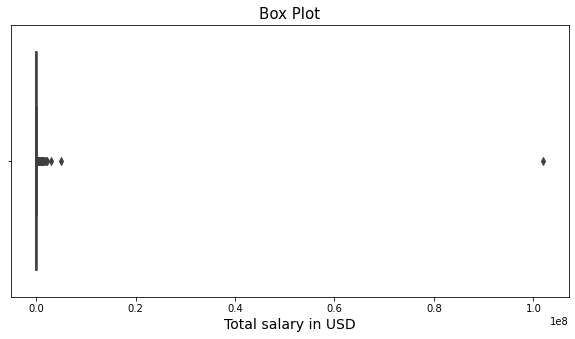

In [97]:
fig = plt.figure(figsize=(10,5))
sns.boxplot(data.total_salary_USD)
plt.title('Box Plot', fontsize=15)
plt.xlabel('Total salary in USD', fontsize=14)
plt.show()

In [102]:
# calculate upper and lower limits
upper_limit = data.total_salary_USD.mean() + 3 * data.total_salary_USD.std()
lower_limit = data.total_salary_USD.mean() -3 * data.total_salary_USD.std()

# show outliers
data[~((data.total_salary_USD < upper_limit) & (data.total_salary_USD > lower_limit))]

,timestamp,age,industry,job_title,annual_salary,additional_salary,currency,country,state,city,...,education_lvl,gender_idx,continent,lat_long,lat,long,USD_rate,annual_salary_USD,additional_salary_USD,total_salary_USD
2124,2021-04-27T11:38:28Z,55-64,Art & Design,Owner and CEO,3000000,NaN,USD,United States,New York,New York,...,4.0,1.0,North America,"(40.7127281, -74.0060152)",40.712728,-74.006015,1.0,3000000.0,NaN,3000000.0
3605,2021-04-27T12:11:17Z,25-34,Utilities & Telecommunications,Operations Manager,102000000,NaN,USD,Colombia,NaN,Bogotá,...,2.0,2.0,South America,"(4.6534649, -74.0836453)",4.653465,-74.083645,1.0,102000000.0,NaN,102000000.0
15509,2021-04-28T17:09:29Z,35-44,Computing or Tech,Product Manager,2111538,84610.0,USD,Singapore,NaN,NaN,...,3.0,2.0,Asia,NaN,NaN,NaN,1.0,2111538.0,84610.0,2196148.0
26466,2021-06-14T04:19:17Z,55-64,Sales,Inside Sales Manager,5000044,4000.0,USD,United States,New Jersey,Babergh,...,4.0,1.0,North America,NaN,NaN,NaN,1.0,5000044.0,4000.0,5004044.0


In [105]:
# remove outliers
data = data.drop(data[~((data.total_salary_USD < upper_limit) & (data.total_salary_USD > lower_limit))].index)

c:\users\wiewi\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


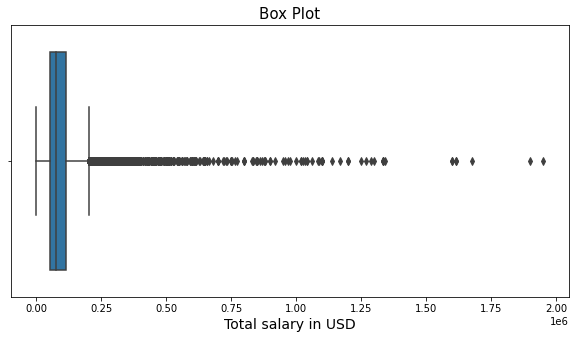

In [106]:
fig = plt.figure(figsize=(10,5))
sns.boxplot(data.total_salary_USD)
plt.title('Box Plot', fontsize=15)
plt.xlabel('Total salary in USD', fontsize=14)
plt.show()

# Indexing
We are forced to treat each record separately.

In [586]:
data['index'] = data.index

# Export data

In [792]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27844 entries, 0 to 27847
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   timestamp               27844 non-null  object 
 1   age                     27844 non-null  object 
 2   industry                27774 non-null  object 
 3   job_title               27844 non-null  object 
 4   annual_salary           27844 non-null  int64  
 5   additional_salary       20632 non-null  float64
 6   currency                27836 non-null  object 
 7   country                 27818 non-null  object 
 8   state                   22198 non-null  object 
 9   city                    27238 non-null  object 
 10  total_experience        27844 non-null  object 
 11  current_experience      27844 non-null  object 
 12  education               27634 non-null  object 
 13  gender                  27679 non-null  object 
 14  race                    27680 non-null

In [793]:
data.to_csv("Data/data_full.csv", index=False)

## Currency table
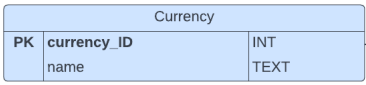

In [681]:
currency_table = data[['currency', 'USD_rate']].copy()

In [682]:
currency_table = currency_table.drop_duplicates()

In [683]:
currency_table['currency_ID'] = range(1, len(currency_table) + 1)

In [684]:
currency_table.head()

,currency,USD_rate,currency_ID
0,USD,1.000000,1
1,GBP,1.380000,2
14,CAD,0.780000,3
117,EUR,1.209000,4
139,AUD,0.694391,5


## Place table
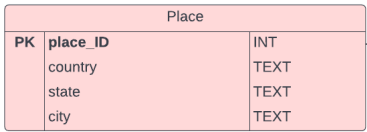

In [685]:
place_table = data[['continent', 'country', 'state', 'city', 'lat', 'long']].copy()

In [686]:
place_table = place_table.drop_duplicates()

In [687]:
place_table['place_ID'] = range(1, len(place_table) + 1)

In [688]:
place_table.head()

,continent,country,state,city,lat,long,place_ID
0,North America,United States,Massachusetts,Boston,42.355433,-71.060511,1
1,Europe,United Kingdom,NaN,Cambridge,52.197585,0.139154,2
2,North America,United States,Tennessee,Chattanooga,35.045722,-85.309488,3
3,North America,United States,Wisconsin,Milwaukee,43.034993,-87.922497,4
4,North America,United States,South Carolina,Greenville,34.851354,-82.398488,5


## Position table
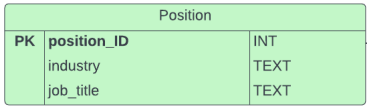

In [689]:
position_table = data[['job_title_clean', 'industry_clean']].copy()

In [690]:
position_table = position_table.rename(columns={"job_title_clean": "job_title", "industry_clean": "industry"})

In [691]:
position_table = position_table.drop_duplicates()

In [692]:
position_table['position_ID'] = range(1, len(position_table) + 1)

In [693]:
position_table.head()

,job_title,industry,position_ID
0,Research And Instruction Librarian,Education (Higher Education),1
1,Change And Internal Communications Manager,Computing Or Tech,2
2,Marketing Specialist,"Accounting, Banking And Finance",3
3,Program Manager,Nonprofits,4
4,Accounting Manager,"Accounting, Banking And Finance",5


## Person table
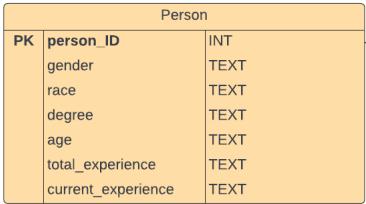

In [694]:
person_table = data[['gender_idx', 'race_idx', 'education_lvl', 'age', 'age_min', 'age_max', 'total_experience', 'total_experience_min', 'total_experience_max', 'current_experience', 'current_experience_min', 'current_experience_max']].copy()

In [695]:
person_table = person_table.drop_duplicates()

In [696]:
person_table['person_ID'] = range(1, len(person_table) + 1)

In [697]:
person_table.head()

,gender_idx,race_idx,education_lvl,age,age_min,age_max,total_experience,total_experience_min,total_experience_max,current_experience,current_experience_min,current_experience_max,person_ID
0,1.0,7,4.0,25-34,25.0,34.0,5-7 years,5.0,7.0,5-7 years,5.0,7.0,1
1,3.0,7,3.0,25-34,25.0,34.0,8 - 10 years,8.0,10.0,5-7 years,5.0,7.0,2
2,1.0,7,3.0,25-34,25.0,34.0,2 - 4 years,2.0,4.0,2 - 4 years,2.0,4.0,3
3,1.0,7,3.0,25-34,25.0,34.0,8 - 10 years,8.0,10.0,5-7 years,5.0,7.0,4
5,2.0,7,4.0,25-34,25.0,34.0,8 - 10 years,8.0,10.0,2 - 4 years,2.0,4.0,5


### Gender lookup table

In [698]:
gender_lookup_table = pd.DataFrame({"Name": ['Woman', 'Man', 'Non-binary', 'Other'], "Index": [1, 2, 3, 4]})

In [699]:
gender_lookup_table.head()

,Name,Index
0,Woman,1
1,Man,2
2,Non-binary,3
3,Other,4


### Race lookup table

In [700]:
race_lookup_table = pd.DataFrame({"Name": list(race_map.keys()), "Index": list(race_map.values())})

In [701]:
race_lookup_table

,Name,Index
0,Asian or Asian American,1
1,Black or African American,2
2,"Hispanic, Latino, or Spanish origin",4
3,Middle Eastern or Northern African,5
4,Native American or Alaska Native,6
5,White,7
6,Another option not listed here or prefer not t...,8


## Employee table
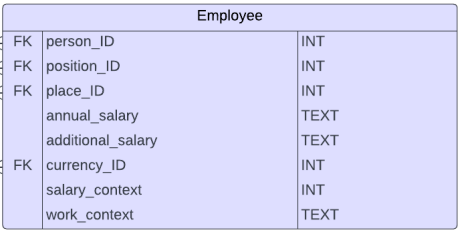

In [765]:
employee_table = pd.DataFrame()

In [789]:
def to_index(row, table, columns, id_column):
    mask = pd.DataFrame(table[columns] == row[columns])
    results = mask.all(axis=1)
    print(table[results])
    return table[results][id_column]

In [790]:
person_table_columns = ['gender_idx', 'race_idx', 'education_lvl', 'age', 'age_min', 'age_max', 'total_experience', 'total_experience_min', 'total_experience_max', 'current_experience', 'current_experience_min', 'current_experience_max']

employee_table['person_ID'] = data.head(20).apply(lambda row: to_index(row, person_table, person_table_columns, 'person_ID'), axis=1)

   gender_idx race_idx  education_lvl    age  age_min  age_max  \
0         1.0        7            4.0  25-34     25.0     34.0   

  total_experience  total_experience_min  total_experience_max  \
0        5-7 years                   5.0                   7.0   

  current_experience  current_experience_min  current_experience_max  \
0          5-7 years                     5.0                     7.0   

   person_ID  
0          1  
   gender_idx race_idx  education_lvl    age  age_min  age_max  \
1         3.0        7            3.0  25-34     25.0     34.0   

  total_experience  total_experience_min  total_experience_max  \
1     8 - 10 years                   8.0                  10.0   

  current_experience  current_experience_min  current_experience_max  \
1          5-7 years                     5.0                     7.0   

   person_ID  
1          2  
   gender_idx race_idx  education_lvl    age  age_min  age_max  \
2         1.0        7            3.0  25-34     25.

In [791]:
employee_table

,person_ID
0,1.0
1,NaN
2,NaN
3,NaN
4,NaN


In [779]:
position_table_columns = ['job_title', 'industry']

employee_table['position_ID'] = data.apply(lambda row: to_index(row, position_table, position_table_columns, 'position_ID'), axis=1)

TypeError: cannot convert the series to <class 'int'>

In [ ]:
place_table_columns = ['continent', 'country', 'state', 'city', 'lat', 'long']

employee_table['place_ID'] = data.apply(lambda row: to_index(row, place_table, place_table_columns, 'place_ID'), axis=1)

In [ ]:
currency_table_columns = ['currency', 'USD_rate']

employee_table['currency_ID'] = data.apply(lambda row: to_index(row, currency_table, currency_table_columns, 'currency_ID'), axis=1)

In [ ]:
salary_columns = ['annual_salary', 'annual_salary_USD', 'additional_salary', 'additional_salary_USD', 'total_salary', 'total_salary_USD']

employee_table[salary_columns] = data[salary_columns].copy()

In [ ]:
employee_table

In [555]:
data[person_table_columns]

,gender_idx,race_idx,education_lvl,age,age_min,age_max,total_experience,total_experience_min,total_experience_max,current_experience,current_experience_min,current_experience_max
0,1.0,7,4.0,25-34,25.0,34.0,5-7 years,5.0,7.0,5-7 years,5.0,7.0
1,3.0,7,3.0,25-34,25.0,34.0,8 - 10 years,8.0,10.0,5-7 years,5.0,7.0
2,1.0,7,3.0,25-34,25.0,34.0,2 - 4 years,2.0,4.0,2 - 4 years,2.0,4.0
3,1.0,7,3.0,25-34,25.0,34.0,8 - 10 years,8.0,10.0,5-7 years,5.0,7.0
4,1.0,7,3.0,25-34,25.0,34.0,8 - 10 years,8.0,10.0,5-7 years,5.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...
27843,4.0,7,3.0,18-24,18.0,24.0,1 year or less,NaN,1.0,1 year or less,NaN,1.0
27844,2.0,7,3.0,18-24,18.0,24.0,2 - 4 years,2.0,4.0,2 - 4 years,2.0,4.0
27845,1.0,4,3.0,35-44,35.0,44.0,5-7 years,5.0,7.0,5-7 years,5.0,7.0
27846,1.0,8,4.0,35-44,35.0,44.0,11 - 20 years,11.0,20.0,11 - 20 years,11.0,20.0
